# Experimental speckle phase retrieval

### Imports and data loading

Load the libraries

In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.io import loadmat
import mat73
import speckleret as spr

import os
import numpy as np
import h5py
import scipy.io
import mat73


def _keep_keys(dictionary: dict, keys_to_keep: list[str]) -> dict:
    if keys_to_keep is None:
        return dictionary
    else:
        return {key: value for key, value in dictionary.items() if key in keys_to_keep}



def load_h5file(filepath: str, keys: list[str] = None) -> dict:
    with h5py.File(filepath, 'r') as hf:
        loaded_data = {}
        for key in hf.keys():
            loaded_data[key] = np.array(hf[key])
    return _keep_keys(loaded_data, keys)



data_path = r'C:\Users\saucourt\Downloads\pr_siwar'
# data_path = 'R:\Axe-Photonique\Phocal\Jérémy Saucourt\datasets_of_41_channel_2_size_at_20251201-150443.h5'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the interferometric data

In [27]:



data = load_h5file(data_path)
print(data.keys())
print(data['data'].shape)


CP = data['data'][..., 0]
CL = data['data'][..., 1]

print(CP.shape)
print(CL.shape)

dict_keys(['data'])
(100, 384, 384, 2)
(100, 384, 384)
(100, 384, 384)


In [18]:
files = [
   r'input frames/input_speckle_for_oam1_0_opt_prewraped_from_20260209-120304_at_20260209-170432.h5',
]

frames_path = files[-1]
file_path = os.path.join(data_path, frames_path)


with h5py.File(file_path, 'r') as f:
    CP = f['img_nf'][:][...,0]  # pour une seule polar
    CL = f['img_ff'][:][...,0]	# pour une seule polar
    CP = np.expand_dims(CP, 0)
    CL = np.expand_dims(CL, 0)

print(CP.shape)
print(CL.shape)

(1, 688, 688)
(1, 688, 688)


In [21]:
data = np.load(data_path)['frames']

CP = data[..., 0]
CL = data[..., 1]

print(CP.shape)
print(CL.shape)

BadZipFile: Bad CRC-32 for file 'frames.npy'

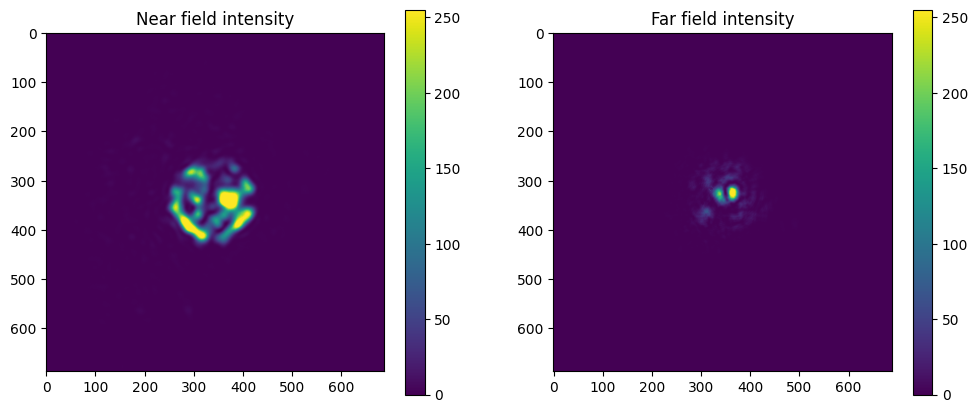

In [24]:
idx = 1
random: bool = True
if random:
    idx = np.random.randint(0, len(CP))

plt.figure(figsize=[12, 5])
plt.subplot(1, 2, 1)
plt.imshow(CP[idx, ...], vmin=0)
plt.title('Near field intensity')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(CL[idx, ...], vmin=0)
plt.title('Far field intensity')
plt.colorbar()

### Data cleanup: noise removal and centroid detection

Let's remove the noise from the measured far field

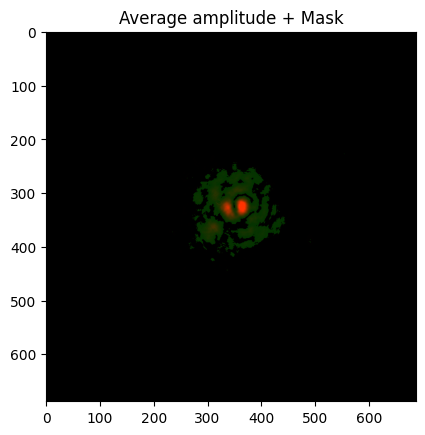

0.03164928677663602


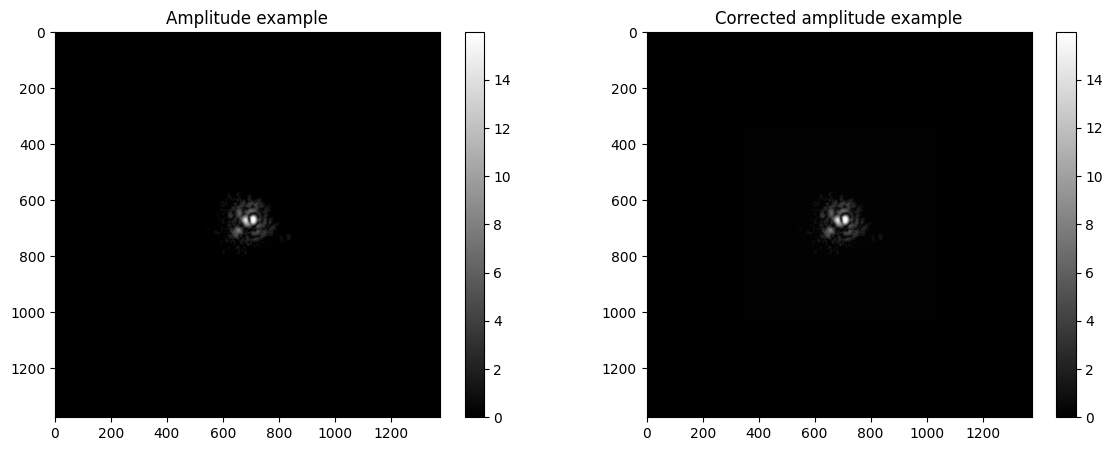

In [25]:
noise_corr = spr.utils.extract_noise_correction(CL, averaging_axis=(0,), mask_trsh=0.01, plot_result=True, plot_mask=True)
print(noise_corr)

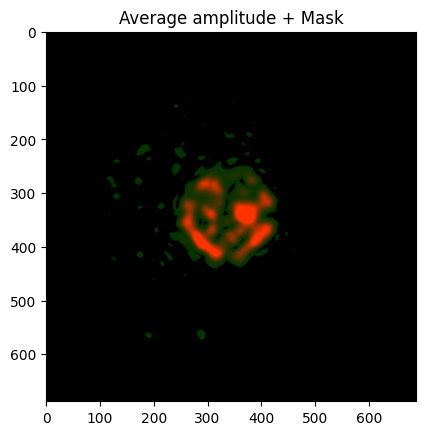

0.09175779137371552


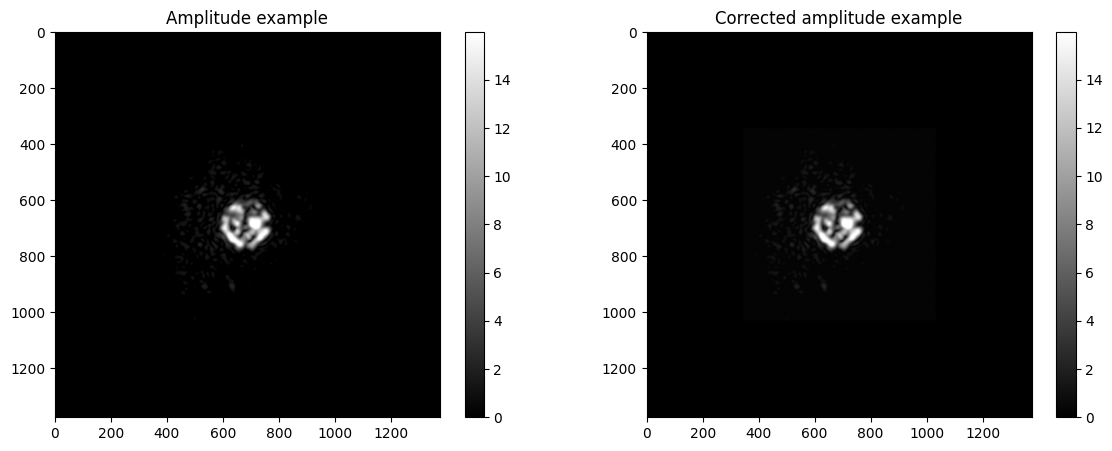

In [30]:
noise_corrCP = spr.utils.extract_noise_correction(CP, averaging_axis=(0,), mask_trsh=0.01, plot_mask=True, plot_result=True)
print(noise_corrCP)

Let's detect the average centroids

In [26]:
centroids_CP = spr.utils.extract_average_centroid(CP, averaging_axis=(-1, -2))
centroids_CL = spr.utils.extract_average_centroid(CL, averaging_axis=(-1, -2))

print(f"Average centroid CP: {centroids_CP}")
print(f"Average centroid CL: {centroids_CL}")

Average centroid CP: (np.float64(0.0), np.float64(344.3490946871624))
Average centroid CL: (np.float64(0.0), np.float64(332.13749549507247))


### Data preparation

Select data for phase retrieval

368
(368, 368) 143779.55797895955
(368, 368) 20870.199265407926


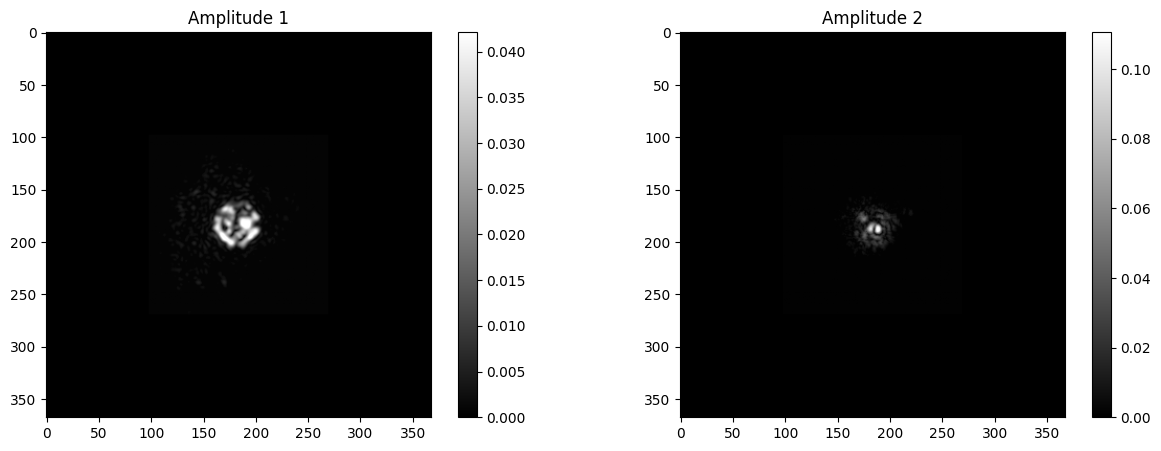

In [31]:
idx = 0
random: bool = False
if random:
    idx = np.random.randint(0, len(CP))


def compute_N_win(wavelength, focal_length, pixel_size1, pixel_size2):
    return int(wavelength * focal_length / (pixel_size1 * pixel_size2))

bin_cp = 4
bin_cl = 4
N_window = compute_N_win(561.4e-9, 125e-3, bin_cp * 3.45e-6, bin_cl * 3.45e-6)
print(N_window)


field = np.sqrt(np.abs(CP[idx, ...] - noise_corrCP)) #

# CP_shift = (np.array(centroids_CP) - np.array(field.shape) / 2).astype(int)
field = spr.utils.bin_image(field, factor=bin_cp)
f_shape = field.shape
f_pad = (N_window - f_shape[0]) // 2
field = np.pad(field, [f_pad, f_pad])

field_energy = np.sum(np.square(np.abs(field)))
field = field / np.sqrt(field_energy)
print(field.shape, field_energy)


ft = np.sqrt(np.abs(CL[idx, ...] - noise_corr)) #
# CL_shift = (np.array(centroids_CL) - np.array(ft.shape) / 2).astype(int) + np.array([-20, 10])
# ft = np.roll(ft, shift=-CL_shift, axis=(0,1))
ft = spr.utils.bin_image(ft, factor=bin_cl)
ft_shape = ft.shape
ft_pad = (N_window - ft_shape[0]) // 2
ft = np.pad(ft, [ft_pad, ft_pad])
ft = np.flip(ft, axis=0)
# ft = np.flip(ft, axis=1)

ft_energy = np.sum(np.square(np.abs(ft)))
ft = ft / np.sqrt(ft_energy)
print(ft.shape, ft_energy)

_ = spr.plots.compare_arrays(field, ft, cmap='gray')

Check that the Fourier transform of the field matches with the measured (perhaps resampled) one. Any shift will lead to a phase slope in the retrieved phase

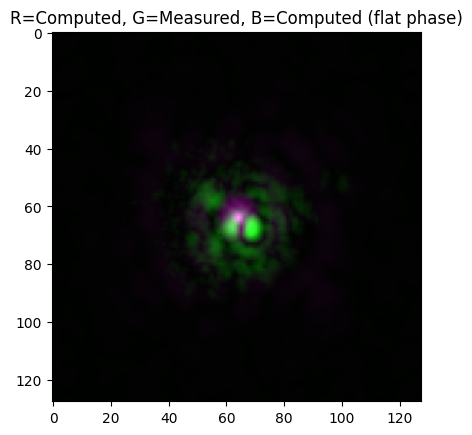

In [34]:
ft_field_flat = spr.transforms.fourier_transform(np.abs(field))
ft_field = spr.transforms.fourier_transform(field)
win_crop = 120

R = np.abs(ft_field[win_crop:-win_crop, win_crop:-win_crop])
G = np.abs(ft[win_crop:-win_crop, win_crop:-win_crop])
B = np.abs(ft_field_flat[win_crop:-win_crop, win_crop:-win_crop])

R /= np.max(R)
G /= np.max(G)
B /= np.max(B)

_ = spr.plots.rgb_imshow([R, G, B])
_ = plt.title("R=Computed, G=Measured, B=Computed (flat phase)")

Define the phase retrieval support

C:\Users\saucourt\dev\venvs\ml313\Lib\site-packages\matplotlib\colors.py:3175: RuntimeWarning: invalid value encountered in cast
  i = (h * 6.0).astype(int)


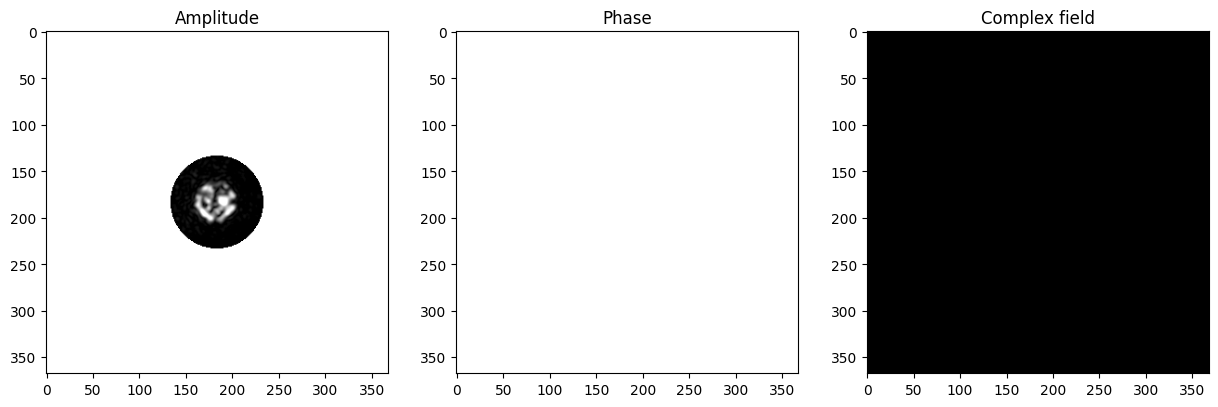

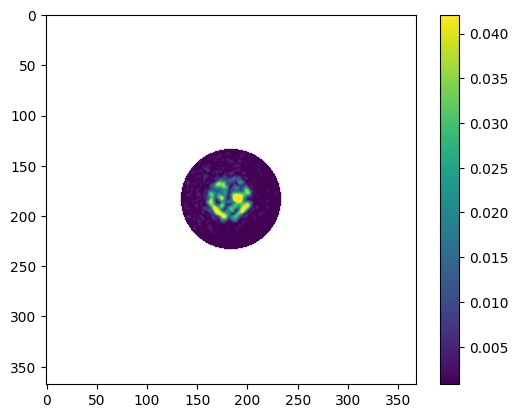

In [35]:
support = spr.supports.threshold_support(field, threshold=0.001)
support = spr.supports.disk_support(field, radius=50, offsets=(0,0))
supported_field = field.copy()
supported_field[np.logical_not(support)] = np.nan
_ = spr.plots.complex_imshow(supported_field)

plt.figure()
plt.imshow(supported_field)
plt.colorbar()

### Testing other phase retrieval algorithms !?!

There are plenty of them based on iterative projections/reflections. It seems that RAAR or OSS works well.

In [36]:
from matplotlib.colors import hsv_to_rgb

def complex_to_hsv(z, rmin, rmax, hue_start=0, power=1):
    # get amplidude of z and limit to [rmin, rmax]
    amp = np.abs(z)
    amp = np.where(amp < rmin, rmin, amp)
    amp = np.where(amp > rmax, rmax, amp)
    amp = np.power(amp, power)
    ph = np.angle(z, deg=True) + hue_start
    # HSV are values in range [0,1]
    h = (ph % 360) / 360
    s = 0.85 * np.ones_like(h)
    v = (amp - rmin) / (rmax - rmin)
    return hsv_to_rgb(np.dstack((h,s,v)))

def merge_dicts(dict_list) -> dict:
    merged_dict = {}
    for d in dict_list:
        for key, array in d.items():
            if key in merged_dict:
                merged_dict[key] = np.concatenate((merged_dict[key], array))
            else:
                merged_dict[key] = array  # Initialize with first occurrence
    return merged_dict

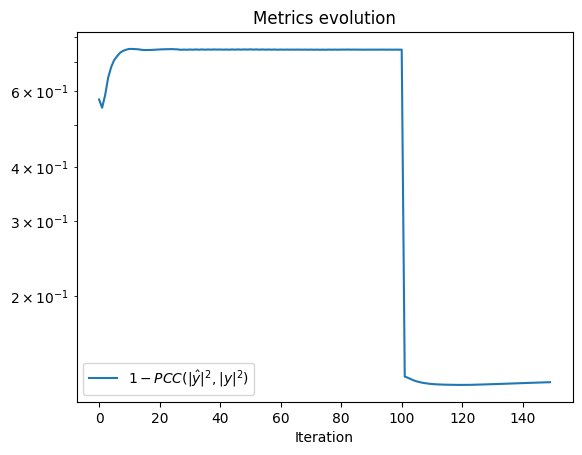

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

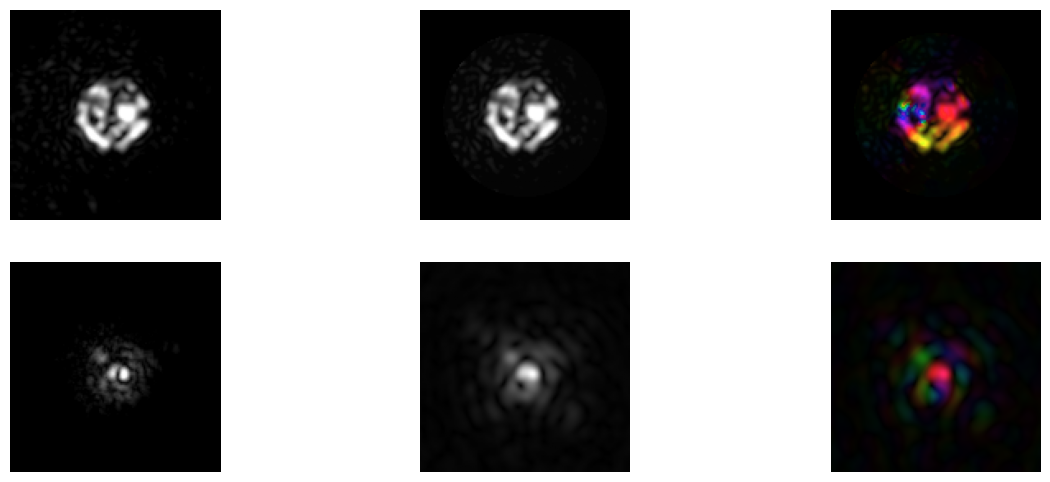

In [37]:
from speckleret.transforms import fourier_transform

results = []

# x, result = spr.retrievalmath.run(
#         magnitudes=(np.abs(field), np.abs(ft)),
#         support=support,
#         init=spr.initializers.flat_phases(magnitude=np.abs(field)),
#         algorithm=spr.retrievalmath.HIO,
#         algorithm_kwargs={'beta': 0.9},
#         max_iter=50,
#         rel_tol=1e-6,
# )
# results.append(result)

x, result = spr.retrievalmath.run(
        magnitudes=(np.abs(field), np.abs(ft)),
        support=support,
        # init=x,
        init=spr.initializers.flat_phases(magnitude=np.abs(field)),
        algorithm=spr.retrievalmath.RAAR,
        algorithm_kwargs={'beta': 0.7},
        max_iter=100,
        rel_tol=1e-6,
)
results.append(result)

# # x = np.abs(field) * np.exp(1j * np.angle(x))

x, result = spr.retrievalmath.run(
        magnitudes=(np.abs(field), np.abs(ft)),
        support=support,
        # init=spr.initializers.flat_phases(magnitude=np.abs(field)),
        init=x,
        algorithm=spr.retrievalmath.ER,
        max_iter=50,
        rel_tol=1e-6,
)
results.append(result)



x_hat = x
# x_hat = np.abs(field) * np.exp(1j * np.angle(x))
# x_hat[np.logical_not(support)] = 0


spr.retrievalmath.report_convergence_results(merge_dicts(results))
plt.show()

y_hat = fourier_transform(x_hat)

win_crop = 120
# _ = spr.plots.complex_imshow(x_hat[win_crop:-win_crop, win_crop:-win_crop], remove_ticks=True, figsize=(12,4))
# plt.show()

plt.figure(figsize=(15, 6))
plt.subplot(2, 3, 1)
plt.imshow(np.abs(field[win_crop:-win_crop, win_crop:-win_crop]), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(np.abs(x_hat[win_crop:-win_crop, win_crop:-win_crop]), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(complex_to_hsv(x_hat[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(x_hat))))
plt.axis('off')
plt.subplot(2, 3, 4)
plt.imshow(np.abs(ft[win_crop:-win_crop, win_crop:-win_crop]), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(np.abs(y_hat[win_crop:-win_crop, win_crop:-win_crop]), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(complex_to_hsv(y_hat[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(y_hat))))
plt.axis('off')